## Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data/array Manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Iteration tools
import itertools
from itertools import chain

# from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Classifier algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Data processing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Feature selection
from sklearn.feature_selection import RFE, RFECV

# Cross validation
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve
)
# Model evaluation
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report,
    roc_curve, auc
)

In [3]:
sns.set_style(style="whitegrid")
np.random.seed(141214)

## Import Data

In [4]:
# Import Data
data = pd.read_csv("data/cancer_diagnosis.csv") 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Feature Selection

### Correlation analysis

#### correlation plot

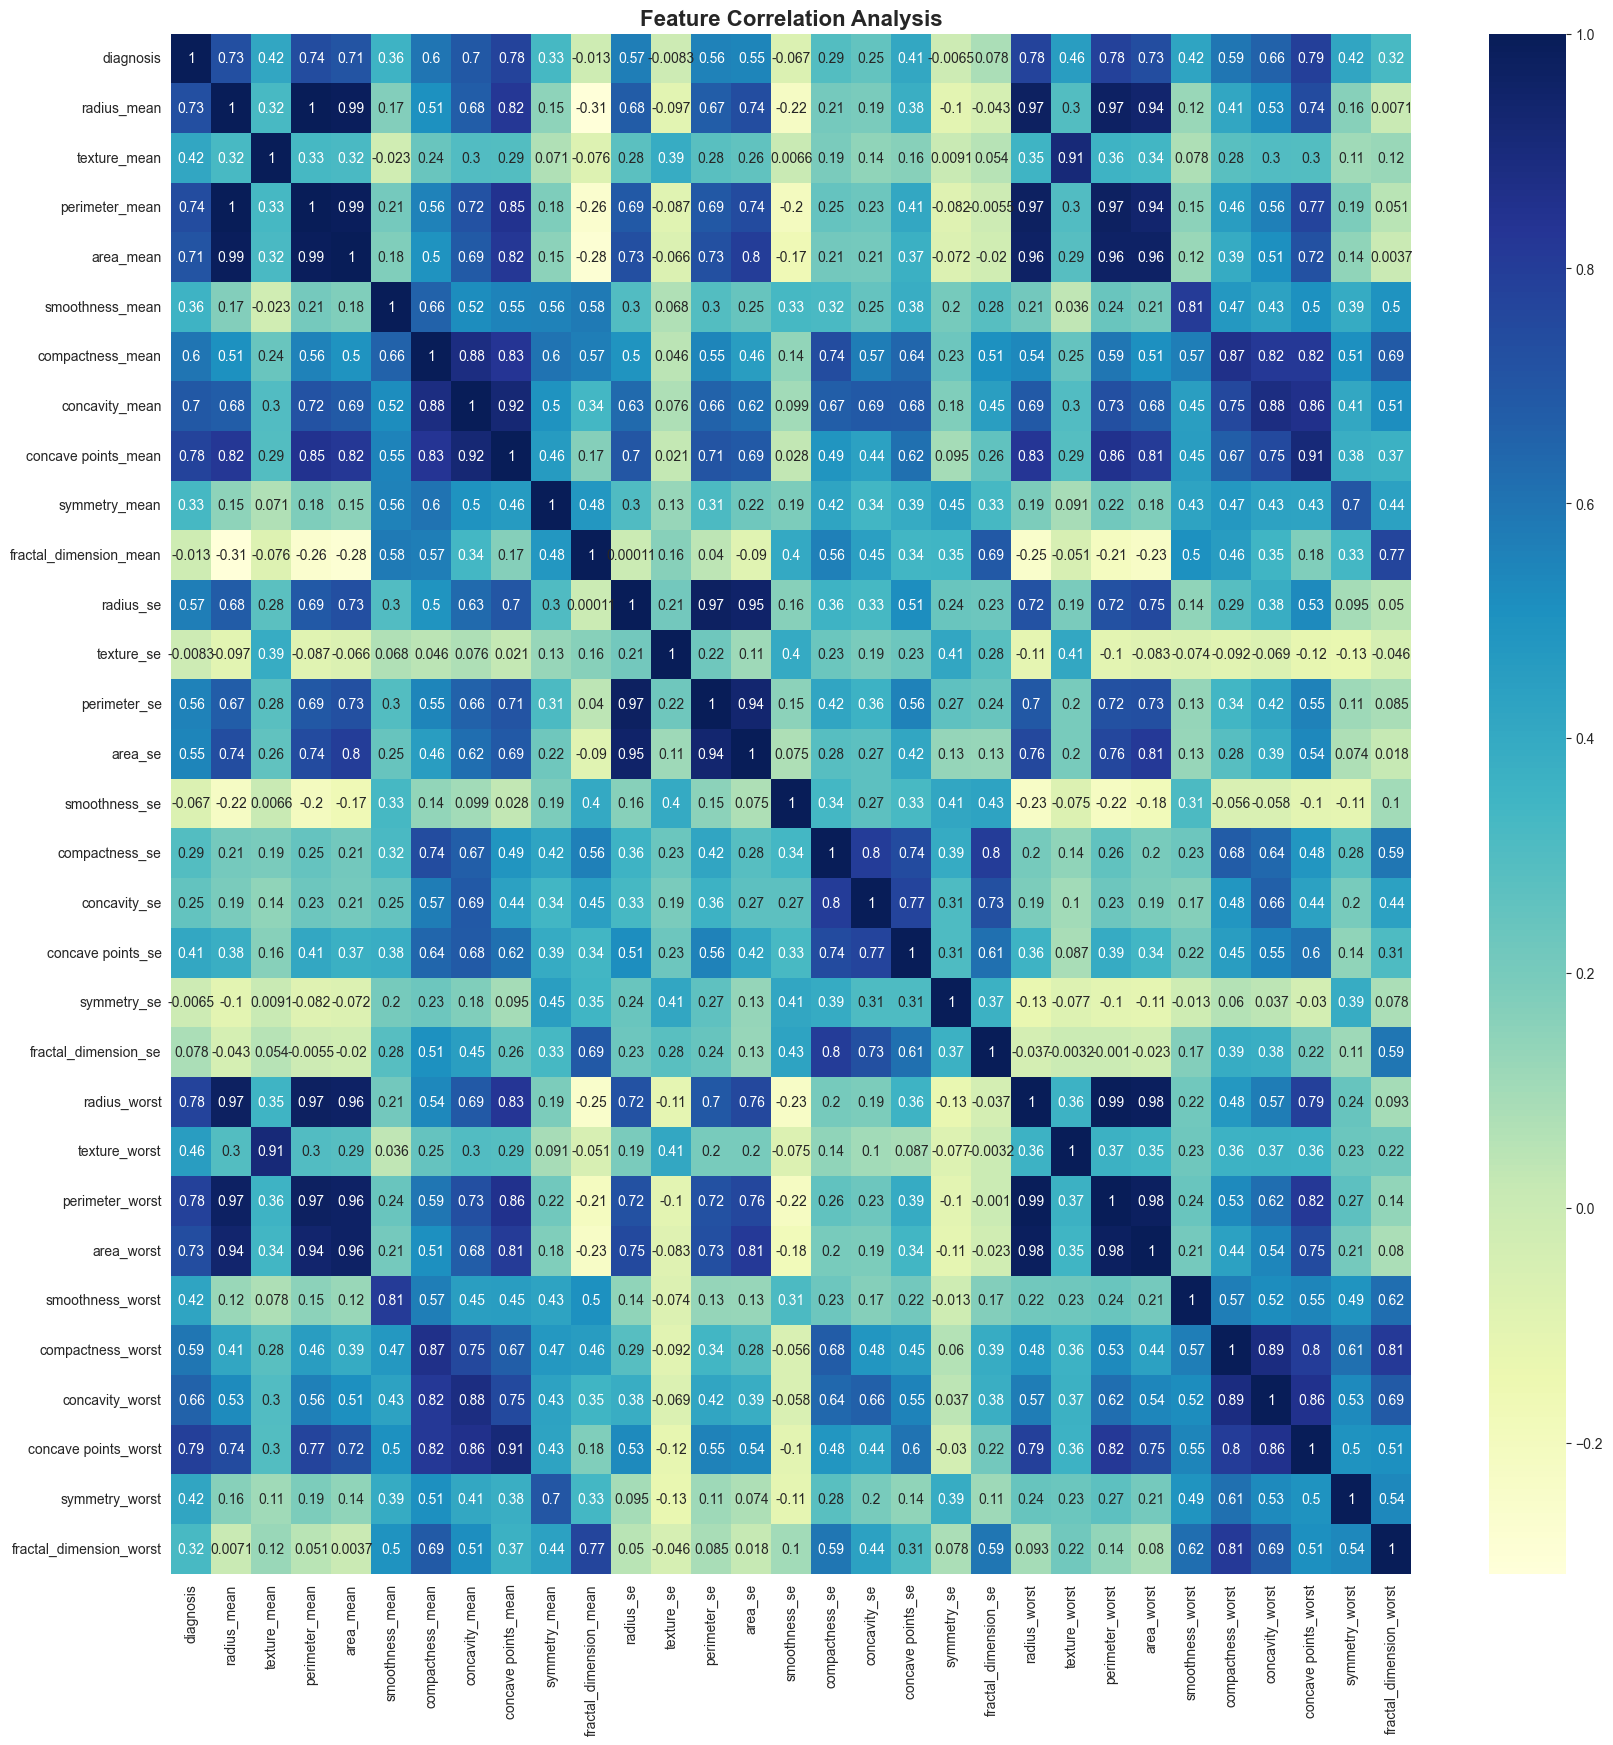

In [6]:
# Copy diagnosis data
corr_df = data.copy()
# Convert diagnosis variable to numeric data-type
corr_df['diagnosis'] = corr_df['diagnosis'].apply(lambda x: 1 if x == 'Malignant' else 0)
# Create correlation matrix 
corr_df = corr_df.corr()
# Plot correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, cmap='YlGnBu', annot=True, annot_kws={"size": 10})
plt.title("Feature Correlation Analysis", fontweight="bold", fontsize=16)
plt.show()

#### Drop highly correlated features

In [7]:
# Get the number features
num_variables = corr_df.shape[0]
# create a column placeholder that contains True values with length of total features
columns_cond = np.full((num_variables,), True, dtype=bool)
# Iterate each column and rows and convert column index with corr value greater then 0.9 to False
for i in range(num_variables):
    for j in range(i+1, num_variables):
        if corr_df.iloc[i, j] >= 0.9:
            columns_cond[j] = False

In [8]:
# Print Highly correlated Features
drop_h_corr_feat = [feat for feat in data.columns if feat not in data.columns[columns_cond]]

drop_h_corr_feat

['perimeter_mean',
 'area_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

In [9]:
# useful features
useful_features = ['radius_worst', 'texture_worst', 'concave points_worst']

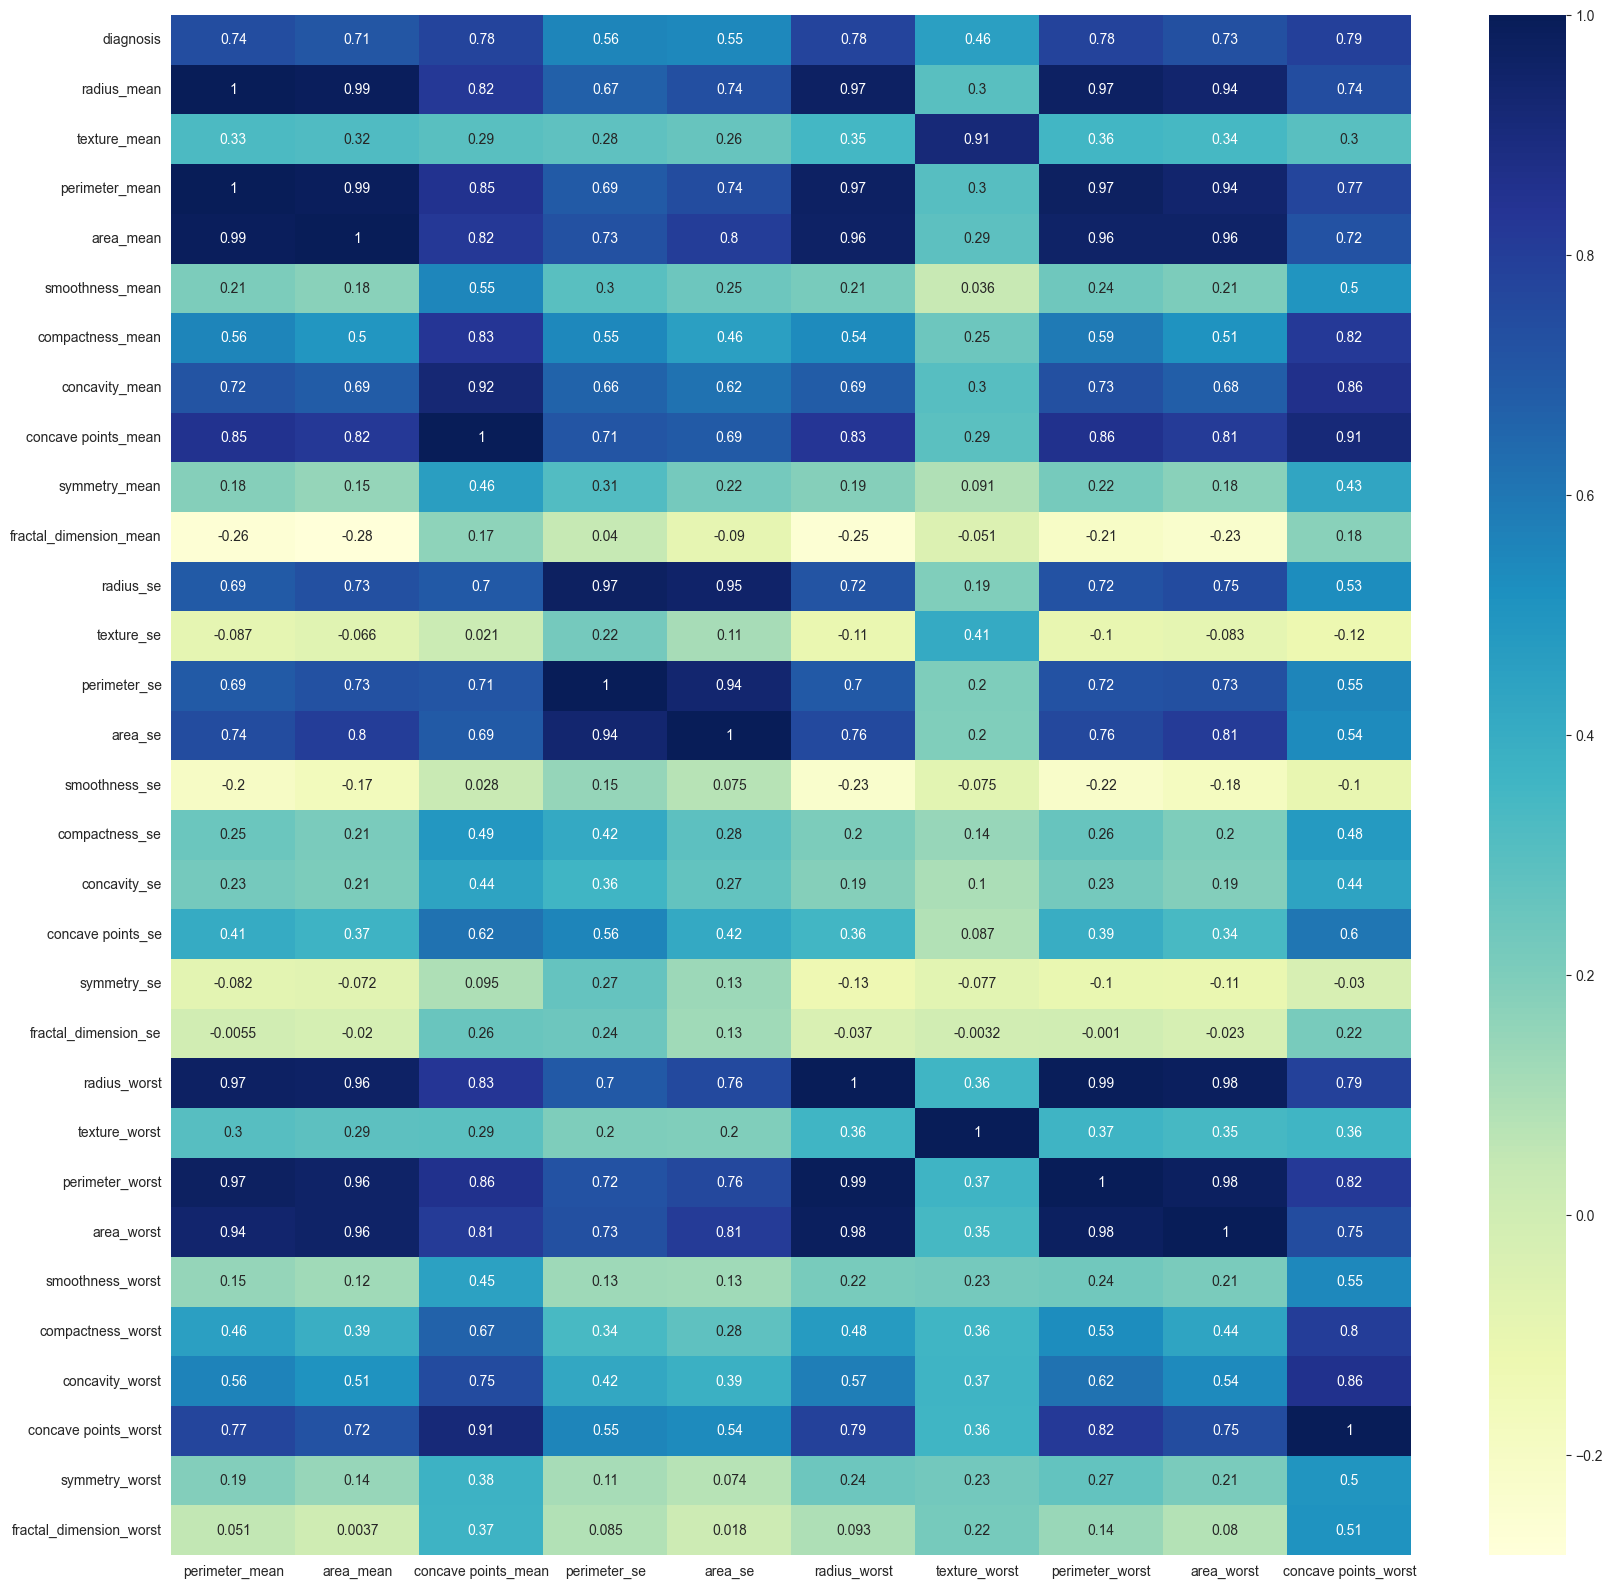

In [11]:
# Plot highly correlated Features
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df[drop_h_corr_feat], cmap='YlGnBu', annot=True, annot_kws={"size": 10})
plt.show()

In [10]:
# Selected Features
selected_columns = list(data.columns[columns_cond]) + useful_features
data = data[selected_columns]

data.shape

(569, 24)

## Feature Engineering

#### Separate variables

In [11]:
# Separate target variable from features
X = data.drop("diagnosis", axis=1)
y = data['diagnosis']

#### Target variable

In [12]:
label_encoder = LabelEncoder()
# Encode diagnosis variable 
y = label_encoder.fit_transform(y)

The Malignant class is encoded as 1 while the Benign class is encoded as 0

#### Split data

In [13]:
# Split data into train set and test set. with 70% and 30% resepectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [14]:
print(f"Shape of X train {X_train.shape}")
print(f"Shape of y train {len(y_train)}")

print(f"Shape of X train {X_test.shape}")
print(f"Shape of X train {len(y_test)}")

Shape of X train (398, 23)
Shape of y train 398
Shape of X train (171, 23)
Shape of X train 171


#### Standard Scaling

In [15]:
ss_scaler = StandardScaler()
# Fit standard scaler
ss_scaler.fit(X_train)

StandardScaler()

In [16]:
# Scale all numeric features 
X_train = ss_scaler.transform(X_train)
X_test = ss_scaler.transform(X_test)

In [17]:
ss_scaler = StandardScaler()
X_scaled = ss_scaler.fit_transform(X)

## Model Training

### Custom functions

In [18]:
def create_cm_plot(cm, classes, plt_title):

    """
    Create a Confusion matrix
    """
    
    tick_marks = np.arange(len(classes))
    sns.set_style(style="white")
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.title(f"{plt_title} Confusion Matrix")
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.0
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, 
            cm[i, j],
            horizontalalignment='center',
            color='white' if cm[i, j] > threshold else 'black'
        )

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

In [19]:
def mdl_scores(y_true, y_pred):
    """
    Calculate the accuracy, precision, recall and F1 metric.

    """
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [21]:
def roc_curve_plot(y_test, proba_score, plt_color, title):
    """
    Create a ROC-AUC curve plot. 
    """
    sns.set_style(style="whitegrid")
    
    # Compute ROC metrics 
    fpr, tpr, thresholds = roc_curve(y_test, proba_score)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # plot the ROC curve
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color=plt_color, lw=2, label=f"ROC curve (area = {roc_auc:0.2f})")
    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"{title} ROC")
    plt.legend(loc="lower right")

In [22]:
def plot_learning_curve(
    model_estimator, 
    X, y,
    title, 
    ylim=None, 
    train_sizes=np.linspace(.1, 1.0, 5)
):
    """
    Create a classification model learning curve. 
    """
    
    sns.set_style(style="whitegrid")
    fig = plt.figure(figsize=(6, 4))
    
    if ylim is not None:
        plt.ylim(*ylim)

    train_sizes, train_scores, test_scores = learning_curve(
        model_estimator, X, y, cv=5, n_jobs=-1, train_sizes = train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#D36135", label="Training score")
    plt.fill_between(
        train_sizes, 
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, 
        alpha=0.1,
        color="#D36135"
    )
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2274A5", label="Test score")
    plt.fill_between(
        train_sizes, 
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, 
        alpha=0.1, 
        color="#2274A5"
    )

    plt.legend()
    plt.xlabel('Samples')
    plt.ylabel('Score')
    plt.title(title)

In [23]:
def compare_mdl_scores(lr_scores:dict, mdl_scores:dict, mdl_title:str, mdl_color:str):

    """
    Create a barchart which compares various metrics of logistic regression and other models. 
    """

    def create_long_table(score_dict:dict, title:str) -> pd.DataFrame:
        return (
            pd.DataFrame(score_dict, index=[0]).T
            .reset_index()
            .rename(columns={"index": "metric", 0: "score"})
            .assign(mdl=title)
        )
    
    # Extract tables
    lr_tbl = create_long_table(lr_scores, "Logistic Reg.")
    mdl_tbl = create_long_table(mdl_scores, mdl_title)
    # Combine tables
    tbl = pd.concat([lr_tbl, mdl_tbl])

    # Plot Evaluation metrics
    fig = plt.figure(figsize=(4, 4))
    sns.barplot(
        data=tbl,
        x="metric",
        y="score",
        hue="mdl",
        width=0.6,
        legend="full",
        palette=["dodgerblue", mdl_color]
    )
    plt.title(f"Metric Comparison of Logistic Regression & {mdl_title}")
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.xlabel("Metric")
    plt.ylabel("Scores")

In [24]:
# Define class
class_names = [0, 1]

### Logistic Regression

In [21]:
LR = LogisticRegression(random_state=12)

# parameter grid
lr_param_grid = {
    'penalty' : ['l2','l1'],  
    'C': [0.001, 0.01, 0.1, 1, 10, 100],            
    'solver': ['lbfgs', 'newton-cg', 'liblinear'],   
    'tol': [1e-4, 1e-3],                             
    'max_iter': [100, 200]                           
}
# Perform cross-validation Grid search 
lr_grid_search = GridSearchCV(LR, lr_param_grid , scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

best_parameters = lr_grid_search.best_params_
print('Logistic Regression', best_parameters)

Logistic Regression {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


In [ ]:
# logistic regression model with best hyperparameters
lr = LogisticRegression(
    C=best_parameters['C'], 
    penalty=best_parameters['penalty'], 
    max_iter=best_parameters['max_iter'], 
    tol=best_parameters['tol'], 
    random_state=12
)
# Train and predict cencer diagnosis
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

In [66]:
# Collect model evalaution metrics 
lr_scores = mdl_scores(y_test, lr_y_pred)

for key, value in lr_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.97
precision Score: 0.98
recall Score: 0.94
f1 Score: 0.96


## Feature Elimination 

### Cross-validation

In [28]:
# Create StratifiedKFold object
Stratified_kfold = StratifiedKFold(n_splits=5)

In [29]:
# Create a logistic regression RFECV instance
rfecv = RFECV(estimator=lr, step=1, cv=Stratified_kfold, scoring="accuracy")

# Fit logistic regression RFECV
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(C=0.1, random_state=12), scoring='accuracy')

In [180]:
# inspect selected features and cross-validation scores:
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Best features: {X.columns[rfecv.support_]}")

Optimal number of features: 11
Best features: Index(['radius_mean', 'texture_mean', 'concavity_mean',
       'fractal_dimension_mean', 'radius_se', 'smoothness_worst',
       'concavity_worst', 'symmetry_worst', 'radius_worst', 'texture_worst',
       'concave points_worst'],
      dtype='object')


### Evaluation

In [181]:
# Convert result dictionary to dataframe
rfe_df = pd.DataFrame(rfecv.cv_results_)
rfe_df

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.914620,0.034738,0.9250,0.8500,0.9500,0.936709,0.911392
1,0.947278,0.012108,0.9500,0.9500,0.9250,0.962025,0.949367
2,0.944715,0.012920,0.9375,0.9500,0.9500,0.962025,0.924051
3,0.947247,0.012265,0.9375,0.9625,0.9375,0.962025,0.936709
4,0.952184,0.021875,0.9500,0.9625,0.9750,0.962025,0.911392
5,0.957247,0.012961,0.9500,0.9750,0.9625,0.962025,0.936709
6,0.962278,0.013811,0.9500,0.9625,0.9875,0.962025,0.949367
7,0.962278,0.011324,0.9500,0.9750,0.9750,0.962025,0.949367
8,0.964778,0.009584,0.9625,0.9750,0.9750,0.949367,0.962025
9,0.969873,0.010018,0.9625,0.9625,0.9750,0.962025,0.987342


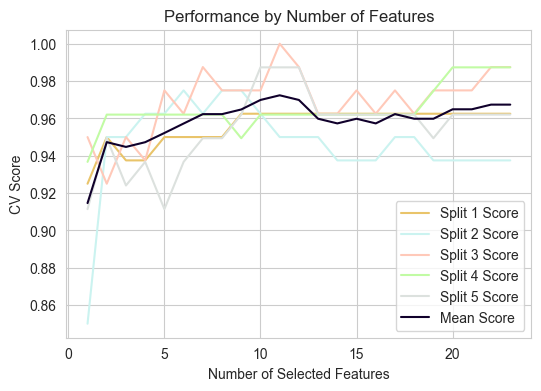

In [273]:
# Plot number of features VS. cross-validation scores
fig = plt.figure(figsize=(6, 4))
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["split0_test_score"], color="#E9C46A", label="Split 1 Score")
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["split1_test_score"], color="#CBF3F0", label="Split 2 Score")
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["split2_test_score"], color="#FFC9B9", label="Split 3 Score")
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["split3_test_score"], color="#C1FBA4", label="Split 4 Score")
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["split4_test_score"], color="#DCE1DE", label="Split 5 Score")
plt.plot(range(1, rfe_df.shape[0] + 1), rfe_df["mean_test_score"], color="#10002B", label="Mean Score")
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Performance by Number of Features")
plt.legend()
plt.savefig("image/RFE.png")
plt.show()

In [182]:
# Predict diagnosis using logistic regression and X_test set
lr_rfe_y_pred = rfecv.predict(X_test)

# Collect model evalaution metrics 
lr_rfe_scores = mdl_scores(y_test, lr_rfe_y_pred)

for key, value in lr_rfe_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.97
precision Score: 1.0
recall Score: 0.92
f1 Score: 0.96


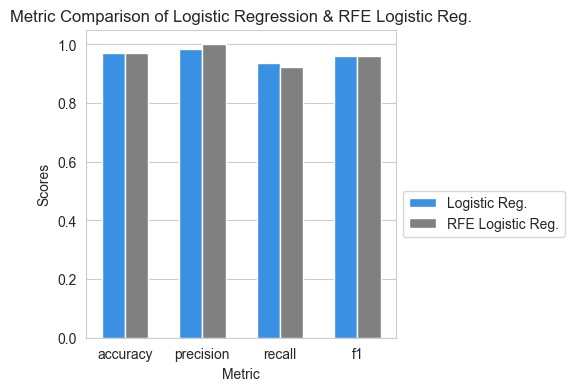

In [272]:
# Compare model performance
compare_mdl_scores(lr_scores, lr_rfe_scores, "RFE Logistic Reg.", "grey")
plt.savefig('image/lr_vs_ref_lr.png', bbox_inches="tight")
plt.show()

## Model Comparison

### Preprocess new selected features

In [32]:
# Select and assign optimal features
X_sl = X[list(X.columns[rfecv.support_])]

In [33]:
# Split selected features data into train and test set
X_sl_train, X_sl_test, y_train, y_test = train_test_split(X_sl, y, test_size=0.3, random_state=12)

In [34]:
# Create a standard scaler instance
ss_scaler = StandardScaler()
# Fit standard scaler
ss_scaler.fit(X_sl_train)

StandardScaler()

In [35]:
# Scale numeric features 
X_sl_train = ss_scaler.transform(X_sl_train)
X_sl_test = ss_scaler.transform(X_sl_test)

In [36]:
all_ss_scaler = StandardScaler()
X_sl_scaled = all_ss_scaler.fit_transform(X_sl)

### Logistic Regression

In [243]:
# Create a logistic regression instance
LR_sl = LogisticRegression(random_state=12)
# Perform cross-validation Grid search 
lr_sl_grid_search = GridSearchCV(LR_sl, lr_param_grid , scoring='accuracy', n_jobs=-1)
lr_sl_grid_search.fit(X_sl_train, y_train)

best_parameters = lr_grid_search.best_params_
print('Logistic Regression', best_parameters)

Logistic Regression {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


In [44]:
# logistic regression model with best hyperparameters
lr_sl = LogisticRegression(
    C=best_parameters['C'], 
    penalty=best_parameters['penalty'], 
    max_iter=best_parameters['max_iter'], 
    tol=best_parameters['tol'], 
    random_state=12
)

# Train and predict cencer diagnosis
lr_sl.fit(X_sl_train, y_train)
lr_sl_y_pred = lr_sl.predict(X_sl_test)

#### Evaluation

In [245]:
# Collect model evalaution metrics 
lr_sl_scores = mdl_scores(y_test, lr_sl_y_pred)

for key, value in lr_sl_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.97
precision Score: 1.0
recall Score: 0.92
f1 Score: 0.96


In [222]:
print(classification_report(y_test, lr_sl_y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



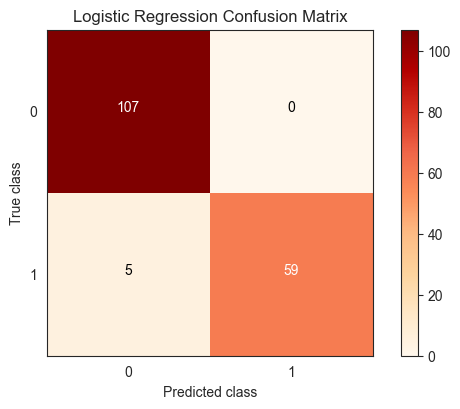

In [258]:
# Model confusion matrix
lr_sl_cm = confusion_matrix(y_test, lr_sl_y_pred)
# plot matrix
create_cm_plot(lr_sl_cm, class_names, 'Logistic Regression')
plt.savefig('image/lr_cm.png')
plt.show()

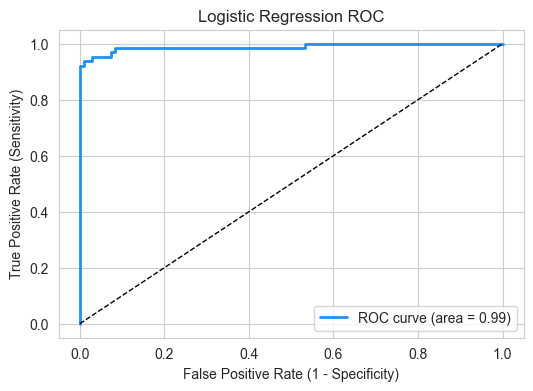

In [259]:
# Get logistic regression prediction probability estimates
lr_sl_y_proba = lr_sl.predict_proba(X_sl_test)[:, 1]
# Plot ROC-AUC curve
roc_curve_plot(y_test, lr_sl_y_proba, "dodgerblue", "Logistic Regression")
plt.savefig('image/lr_roc_curve.png')
plt.show()

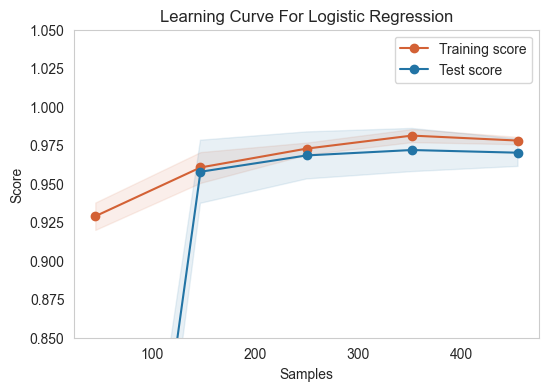

In [220]:
# Train and plot model learning curve
plot_learning_curve(lr_sl, X_sl_scaled, y, 'Learning Curve For Logistic Regression', (0.85, 1.05))
plt.savefig('image/lr_learn_curve.png')
plt.show()

In [255]:
# Retrieve the coefficients and odds ratio
coefficients = lr_sl.coef_
intercept = lr_sl.intercept_
feature_names = X_sl.columns
odds_ratio = np.exp(coefficients)

# Store variables as a dataframe
coefficient_df = pd.DataFrame({
    "feature": feature_names,
    "coeff": coefficients[0],
    "abs_coeff": np.abs(coefficients[0]),
    "odd_ratio": odds_ratio[0]
}).sort_values(by="coeff", ascending=False).reset_index(drop=True)

coefficient_df

,feature,coeff,abs_coeff,odd_ratio
0,radius_worst,0.943505,0.943505,2.568971
1,radius_mean,0.870723,0.870723,2.388637
2,concave points_worst,0.720968,0.720968,2.056422
3,radius_se,0.720040,0.720040,2.054515
4,smoothness_worst,0.532245,0.532245,1.702750
5,concavity_mean,0.445911,0.445911,1.561912
6,symmetry_worst,0.422154,0.422154,1.525243
7,texture_worst,0.419038,0.419038,1.520498
8,texture_mean,0.380388,0.380388,1.462852
9,concavity_worst,0.372616,0.372616,1.451526


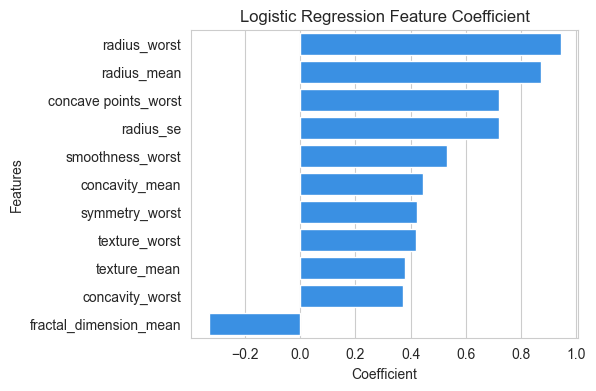

In [270]:
# Create model Feature coefficient plot
fig = plt.figure(figsize=(5, 4))

sns.barplot(
    data=coefficient_df,
    x="coeff",
    y="feature",
    color="dodgerblue"
)
plt.title("Logistic Regression Feature Coefficient")
plt.xlabel("Coefficient")
plt.ylabel("Features")
plt.savefig("image/lr_coeff_plot.png", bbox_inches="tight")
plt.show()

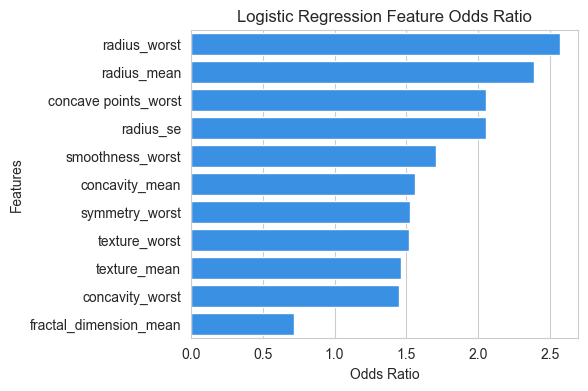

In [271]:
# Create model odds ratio plot
fig = plt.figure(figsize=(5, 4))
sns.barplot(
    data=coefficient_df,
    x="odd_ratio",
    y="feature",
    color="dodgerblue"
)
plt.title("Logistic Regression Feature Odds Ratio")
plt.xlabel("Odds Ratio")
plt.ylabel("Features")
plt.savefig("image/lr_odds_ratio_plot.png", bbox_inches="tight")
plt.show()

### K-Nearest Neighbors Classifier

In [208]:
# Create a K-Neighbors Classifier instance
knn = KNeighborsClassifier()

# parameter grid
knn_param_grid = {
    'n_neighbors': range(1, 21),           
    'weights': ['uniform', 'distance'],    
    'metric': ['euclidean', 'manhattan'],  
    'algorithm': ['auto', 'ball_tree']     
}

# Perform cross-validation Grid search 
knn_grid_search = GridSearchCV(knn, knn_param_grid, scoring="accuracy", cv=5, n_jobs=-1)
knn_grid_search.fit(X_sl_train, y_train)

knn_best_parameters = knn_grid_search.best_params_
print('K-Nearest Neighbors', knn_best_parameters)

K-Nearest Neighbors {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


In [48]:
# K-Neighbors Classifier model with best hyperparameters
knn = KNeighborsClassifier(
    n_neighbors=knn_best_parameters['n_neighbors'], 
    weights=knn_best_parameters['weights'], 
    metric=knn_best_parameters['metric'], 
    algorithm=knn_best_parameters['algorithm']
)

# Train and predict cencer diagnosis
knn.fit(X_sl_train, y_train)
knn_y_pred = knn.predict(X_sl_test)

#### Evaluation

In [215]:
# Collect model evalaution metrics 
knn_scores = mdl_scores(y_test, knn_y_pred)

for key, value in knn_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.95
precision Score: 0.98
recall Score: 0.89
f1 Score: 0.93


In [216]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       107
           1       0.98      0.89      0.93        64

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



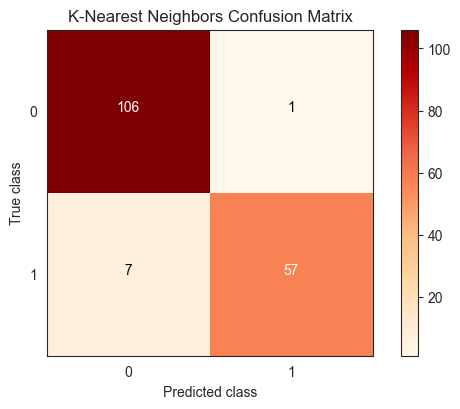

In [260]:
# Model confusion matrix
knn_cm = confusion_matrix(y_test, knn_y_pred)
# plot matrix
create_cm_plot(knn_cm, class_names, 'K-Nearest Neighbors')
plt.savefig('image/knn_cm.png')
plt.show()

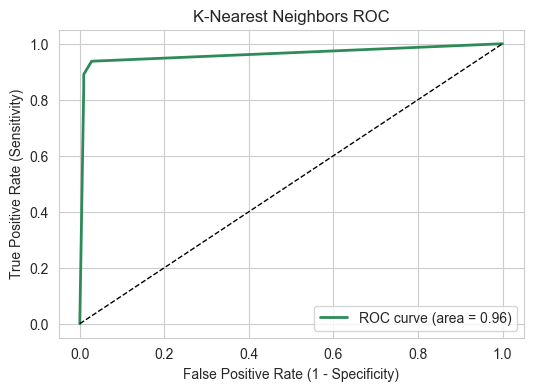

In [218]:
# Get K-Neighbors Classifier prediction probability estimates
knn_y_proba = knn.predict_proba(X_sl_test)[:, 1]
# Plot ROC-AUC curve
roc_curve_plot(y_test, knn_y_proba, "seagreen", "K-Nearest Neighbors")
plt.savefig('image/knn_roc_curve.png')
plt.show()

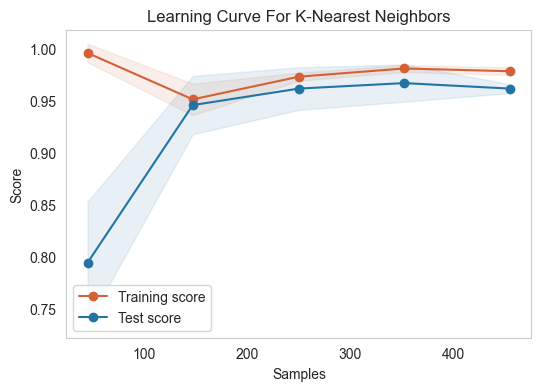

In [221]:
# Train and plot model learning curve
plot_learning_curve(knn, X_sl_scaled, y, 'Learning Curve For K-Nearest Neighbors')
plt.savefig('image/knn_learn_curve.png')
plt.show()

##### Comparison

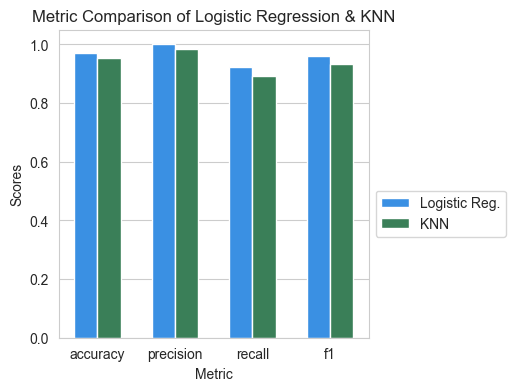

In [274]:
# compare model performance
compare_mdl_scores(lr_sl_scores, knn_scores, "KNN", "seagreen")
plt.savefig('image/lr_vs_knn.png', bbox_inches="tight")
plt.show()

### Support Vector Classifier

In [225]:
# Create a Support Vector Classifier instance
svc = SVC()

# Parameter grid
svc_param_grid = {
    'gamma' : [0.001, 0.01, 0.1],
    'C' : [0.05, 0.5, 0.1, 1, 10, 20, 100]    
}

# Perform cross-validation Grid search 
svc_grid_search = GridSearchCV(svc, svc_param_grid, scoring="accuracy", cv=5, n_jobs=-1)
svc_grid_search.fit(X_sl_train, y_train)

svc_best_parameters = svc_grid_search.best_params_
print('Support Vector Machine', svc_best_parameters)

Support Vector Machine {'C': 10, 'gamma': 0.01}


In [52]:
# Support Vector Classifier model with best hyperparameters
svc = SVC(
    C=svc_best_parameters['C'], 
    gamma=svc_best_parameters['gamma'],
    random_state=12
)

# Train and predict cencer diagnosis
svc.fit(X_sl_train, y_train)
svc_y_pred = svc.predict(X_sl_test)

#### Evaluate

In [227]:
# Collect model evalaution metrics 
svc_scores = mdl_scores(y_test, knn_y_pred)

for key, value in svc_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.95
precision Score: 0.98
recall Score: 0.89
f1 Score: 0.93


In [228]:
print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       107
           1       0.98      0.94      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



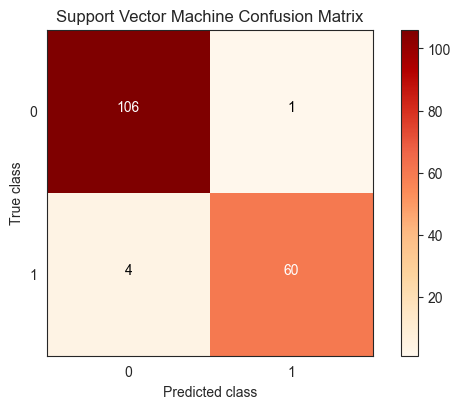

In [262]:
# Model confusion matrix
svc_cm = confusion_matrix(y_test, svc_y_pred)
# Plot matrix
create_cm_plot(svc_cm, class_names, 'Support Vector Machine')
plt.savefig('image/svm_cm.png')
plt.show()

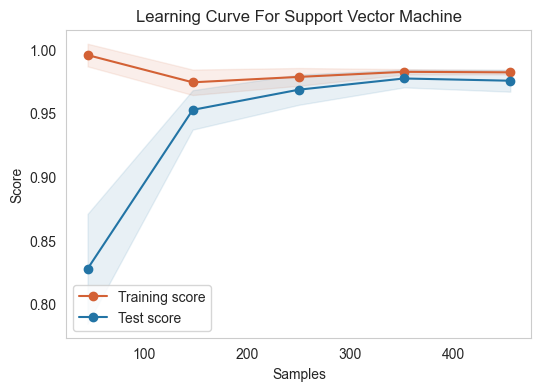

In [231]:
# Get Support Vector Classifier prediction probability estimates
plot_learning_curve(svc, X_sl_scaled, y, 'Learning Curve For Support Vector Machine')
plt.savefig('image/svm_learn_curve.png')
plt.show()

##### Comparison

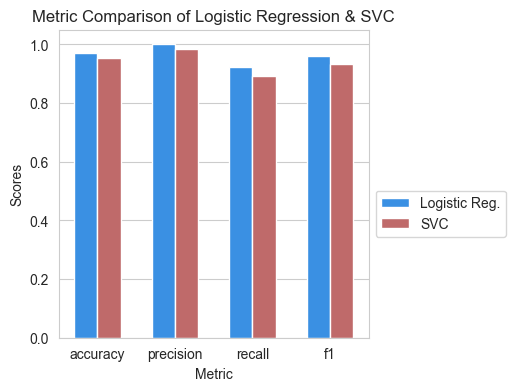

In [275]:
# Train and plot model learning curve
compare_mdl_scores(lr_sl_scores, svc_scores, "SVC", "indianred")
plt.savefig('image/lr_vs_svc.png', bbox_inches="tight")
plt.show()

### Gradient Boosting Classifier

In [235]:
# Create a Gradient Boosting Classifier instance
gbc = GradientBoostingClassifier(random_state=12)

# Parameter grid
gbc_param_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],    
    'n_estimators': [100, 150, 180, 200],    
    'max_depth': [3, 5, 8],                  
}

# Perform cross-validation Grid search 
gbc_grid_search = GridSearchCV(gbc, gbc_param_grid, cv=5, n_jobs=-1, scoring="accuracy")
gbc_grid_search.fit(X_sl_train, y_train)

gbc_best_parameters = gbc_grid_search.best_params_
print('Gradient Boosting best params:\n', gbc_best_parameters)

Gradient Boosting best params:
 {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 100}


In [56]:
# Gradient Boosting Classifier model with best hyperparameters
gbc = GradientBoostingClassifier(
    loss=gbc_best_parameters['loss'], 
    learning_rate=gbc_best_parameters['learning_rate'],
    n_estimators=gbc_best_parameters['n_estimators'],
    max_depth=gbc_best_parameters['max_depth'],
    random_state=12
)

# Train and predict cencer diagnosis
gbc.fit(X_sl_train, y_train)
gbc_y_pred = gbc.predict(X_sl_test)

#### Evaluate

In [237]:
# Collect model evalaution metrics 
gbc_scores = mdl_scores(y_test, gbc_y_pred)

for key, value in gbc_scores.items():
    print(f"{key} Score: {round(value, 2)}")

accuracy Score: 0.94
precision Score: 0.95
recall Score: 0.89
f1 Score: 0.92


In [238]:
print(classification_report(y_test, gbc_y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       107
           1       0.95      0.89      0.92        64

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.94       171
weighted avg       0.94      0.94      0.94       171



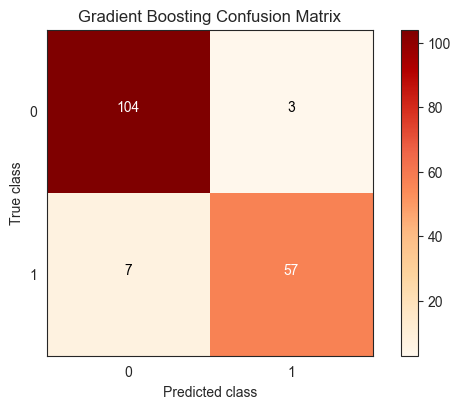

In [276]:
# Model confusion matrix
gbc_cm = confusion_matrix(y_test, gbc_y_pred)
# Plot Matrix
create_cm_plot(gbc_cm, class_names, 'Gradient Boosting')
plt.savefig('image/gb_learn_curve.png')
plt.show()

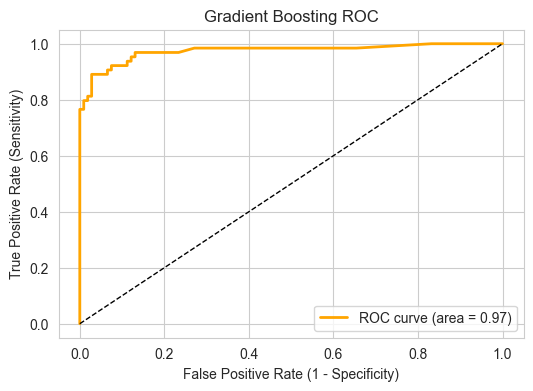

In [240]:
# Get Gradient Boosting Classifier prediction probability estimates
gbc_y_proba = gbc.predict_proba(X_sl_test)[:, 1]
# Plot ROC-AUC curve
roc_curve_plot(y_test, gbc_y_proba, "orange", "Gradient Boosting")
plt.savefig('image/gbc_roc_curve.png')
plt.show()

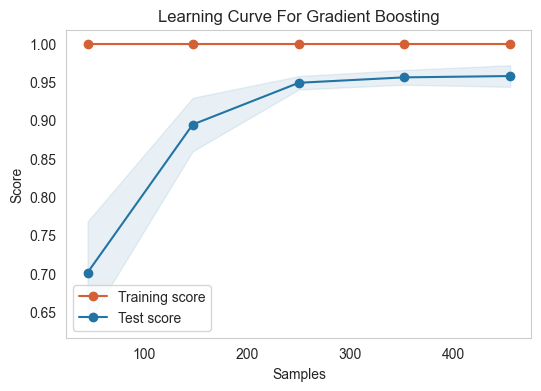

In [241]:
# Get Gradient Boosting Classifier prediction probability estimates
plot_learning_curve(gbc, X_sl_scaled, y, 'Learning Curve For Gradient Boosting')
plt.savefig('image/gb_learn_curve.png')
plt.show()

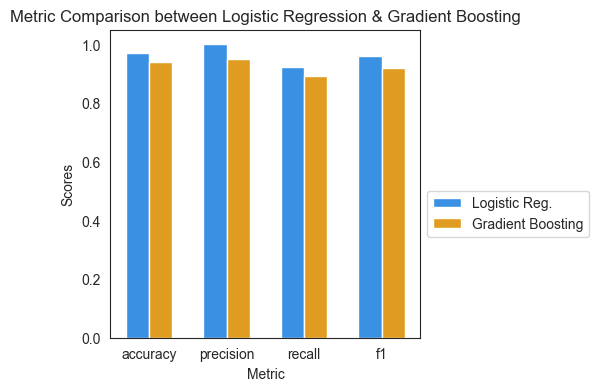

In [277]:
# Train and plot model learning curve
compare_mdl_scores(lr_sl_scores, gbc_scores, "Gradient Boosting", "orange")
plt.savefig('image/lr_vs_gbc.png', bbox_inches="tight")
plt.show()

## Evaluation Summary

In [68]:
def to_dataframe(metric_dict, mdl_name):
    fun_df = pd.DataFrame(metric_dict, index=[0])
    fun_df["Model"] = mdl_name
    return fun_df

mdl_metics =  pd.concat(
    [
        to_dataframe(lr_sl_scores, "Logistic Regression"),
        to_dataframe(svc_scores, "Support Vector Machine"),
        to_dataframe(knn_scores, "K-nearest Neighbors"),
        to_dataframe(gbc_scores, "Gradient Boosting")
    ]
).reset_index(drop=True)

mdl_metics[["Model", "accuracy", "precision", "recall", "f1"]]

,Model,accuracy,precision,recall,f1
0,Logistic Regression,0.970760,1.000000,0.921875,0.959350
1,Support Vector Machine,0.953216,0.982759,0.890625,0.934426
2,K-nearest Neighbors,0.953216,0.982759,0.890625,0.934426
3,Gradient Boosting,0.941520,0.950000,0.890625,0.919355
